In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.widgets as wid
import scipy.signal as sig
import scipy.signal.windows as win
from numpy.random import default_rng
rng = default_rng()

## Partie 2

### Définition d'une convolution

In [3]:
def convolve_1d(x, h):
    m = len(h)
    n = len(x)
    x_padded = np.pad(x, (m, m), constant_values=(0,))
    y = np.zeros(n + 2 * m)
    for i in range(len(y)):
       for j in range(m):
          y[i] += h[j] * x_padded[i - j]
    return y

In [4]:
def show_part2_convolve(n, m):
    h = np.empty(m)
    h.fill(1/m)
    x = rng.random(n) + np.arange(n)
    y = convolve_1d(x, h)
    plt.figure(figsize=(8, 6))
    # plt.subplot(2, 1, 1)
    plt.plot(x)
    # plt.subplot(2, 1, 2)
    plt.plot(y)

### Observations

On constate un régime transitoire au début et à la fin de la sortie du filtre.
Le retard est de $m$ de chaque côté.

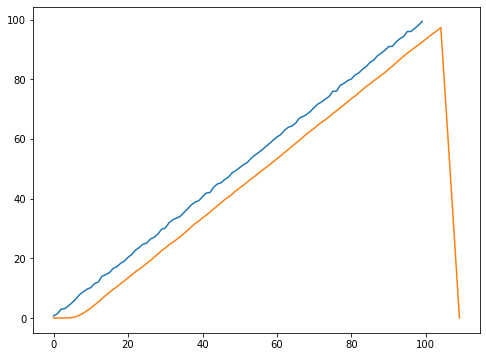

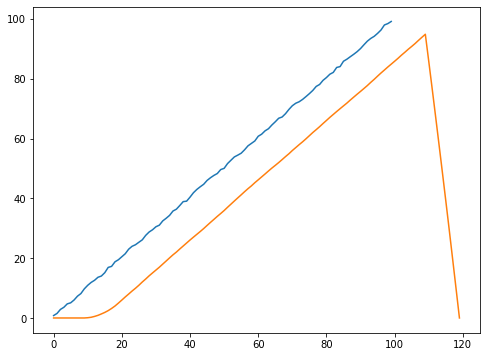

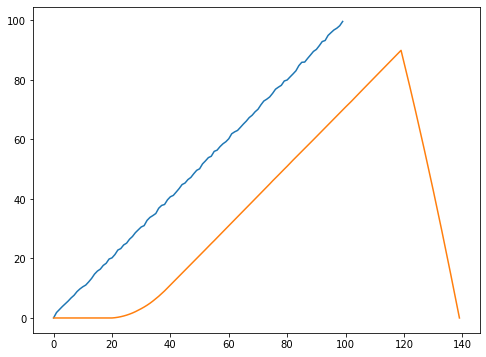

In [5]:
n = 100
m = 5
show_part2_convolve(n, m)
m = 10
show_part2_convolve(n, m)
m = 20
show_part2_convolve(n, m)

### Affichage d'un sinus, Stroboscopie

In [6]:
def s(n, nu_0):
    return np.sin(2 * np.pi * nu_0 * np.arange(n))

def show_part2_stroboscopy(s, nu_0_min, nu_0_max):
    # source : http://www.math.buffalo.edu/~badzioch/MTH337/PT/PT-matplotlib_slider/PT-matplotlib_slider.html
    fig = plt.figure(figsize=(8,3))

    # first we create the general layount of the figure
    # with two axes objects: one for the plot of the function
    # and the other for the slider
    sin_ax = plt.axes([0.1, 0.2, 0.8, 0.65])
    slider_ax = plt.axes([0.1, 0.05, 0.8, 0.05])


    # in plot_ax we plot the function with the initial value of the parameter a
    plt.axes(sin_ax) # select sin_ax
    plt.title('y(n) = sin(2pi * nu_0 * n)')
    sin_plot, = plt.plot(s, 'r')
    # plt.xlim(0, 2*np.pi)
    plt.ylim(-1.1, 1.1)

    # here we create the slider
    a_slider = wid.Slider(slider_ax,      # the axes object containing the slider
                    'nu_0',            # the name of the slider parameter
                    nu_0_min,          # minimal value of the parameter
                    nu_0_max,          # maximal value of the parameter
                    valinit=nu_0  # initial value of the parameter
                    )

    # Next we define a function that will be executed each time the value
    # indicated by the slider changes. The variable of this function will
    # be assigned the value of the slider.
    def update(nu_0):
        sin_plot.set_ydata(s(nu_0, n)) # set new y-coordinates of the plotted points
        fig.canvas.draw_idle()          # redraw the plot

    # the final step is to specify that the slider needs to
    # execute the above function when its value changes
    a_slider.on_changed(update)

    plt.show()

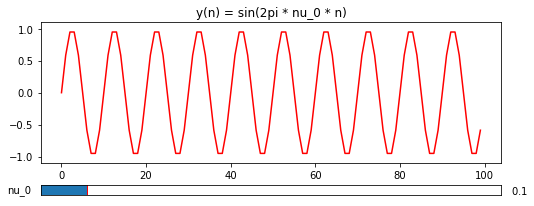

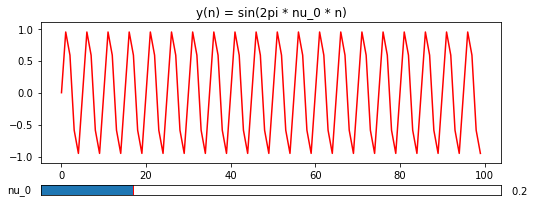

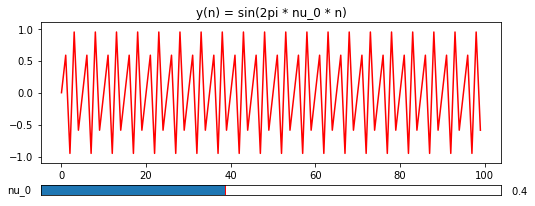

In [7]:
nu_0_min = 0
nu_0_max = 1

nu_0 = 0.1 # fréquence réduite
show_part2_stroboscopy(s(n, nu_0), nu_0_min, nu_0_max)

nu_0 = 0.2 # fréquence réduite
show_part2_stroboscopy(s(n, nu_0), nu_0_min, nu_0_max)


nu_0 = 0.4 # fréquence réduite
show_part2_stroboscopy(s(n, nu_0), nu_0_min, nu_0_max)



## Exercice 4 : Observation du spectre par la TFD

### À FAIRE

## Exercice 5 : Réalisation d'une loupe spectrale

In [8]:
def s(n, nu_0, nu_m, beta):
    r = np.arange(n)
    return np.cos(2 * np.pi * nu_0 * r + beta * np.sin(2 * np.pi * nu_m * r))

def get_fft_mod(s):
    fs = np.fft.fftfreq(len(s))
    mfft = np.abs(np.fft.fft(s))
    return (fs, mfft)
    # return np.abs(np.fft.fftshift(np.fft.fft(s)))
    

In [9]:
def delay(n, nu_delay):
    # translation de nu_0 la TF : retard de nu_0 en temps.
    return np.exp(2 * 1j * np.pi * nu_delay * np.arange(n))

def get_filter_order(nu_c, nu_a, delta_1, delta_2):
    return max(2, int(np.round((2/3) * (-np.log10(10 * delta_1 * delta_2)) / (nu_a - nu_c))))

def get_h(m, nu_c, nu_a, l_minus_1):
    return sig.remez(l_minus_1, [0, nu_c, nu_a, 0.5], [m, 0])

def decim(x, m):
    n = len(x) // m
    res = x[np.arange(n) * m]
    return res

In [11]:
# Posés
nu_0 = 0.3
beta = 10
nu_m = 0.0005
n = 256

delta_nu = 3 * nu_m * (beta + 1) # AN = 0.0165

# Déterminé théoriquement (cf. plus bas)
nu_c = delta_nu / 2 # AN: 0.00825
nu_a = 1 - 2 * nu_0 - delta_nu / 2 # AN: 0.39175


m = 16 # np1 / (3 * (beta + 1) * nu_m) # 16
p = 2 * m

# Déterminés empiriquement

delta_1 = 0.01
delta_2 = 0.001



### Spectres

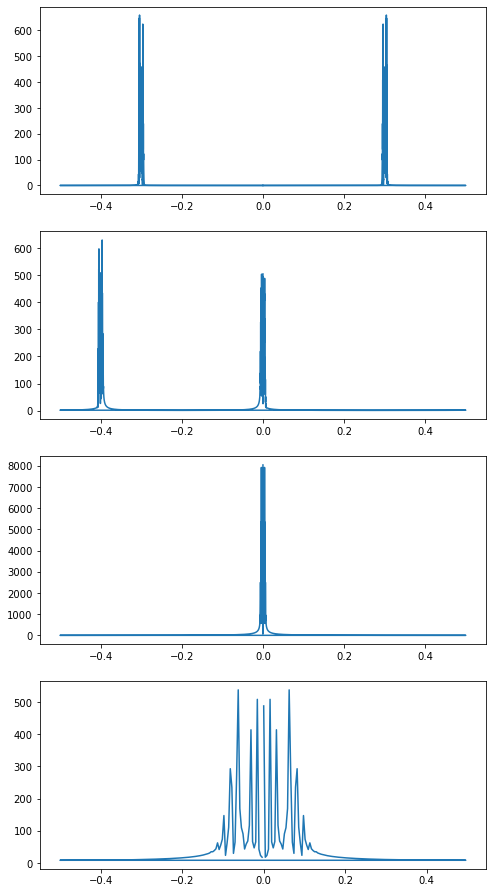

In [12]:
plt.figure(figsize=(8, 20))

x = s(n*m + p, nu_0, nu_m, beta)
plt.subplot(5, 1, 1)
plt.plot(*get_fft_mod(x))

x1 = np.multiply(x, delay(len(x), nu_0))
plt.subplot(5, 1, 2)
plt.plot(*get_fft_mod(x1))

l_minus_1 = get_filter_order(nu_c, nu_a, delta_1, delta_2)
# print(l_minus_1)
h = get_h(m, nu_c, nu_a, l_minus_1)
x2 = convolve_1d(x1,h)
x2 = x2[p//2:-p//2] # tronqué de p échantillions en tout.
plt.subplot(5, 1, 3)
# plt.plot(h)
plt.plot(*get_fft_mod(x2))

x3 = decim(x2, m)
plt.subplot(5, 1, 4)
plt.plot(*get_fft_mod(x3))

y = np.multiply(x3, delay(len(x3), 0.5))
# plt.subplot(5, 1, 5)
# plt.plot(get_fft_mod(y))

plt.show()


### Compréhension

Avec un spectre non centré sur zéro, c'est-à-dire sans modulation, avec M suffisamment grand le signal sera distordu par repliement.
Graphiquement, on doit avoir :
$$
M \leq \frac{1}{\Delta \nu} 
$$
Par Carson et application numérique :
$$
M \leq \frac{1}{3(\beta + 1)\nu_m} \approx 20,5
$$
Car $M$ doit être une puissance de 2, $M = 16$.

### Synthèse du filtre

Déterminer $\nu_c$ et $\nu_a$ 
On doit avoir :
- $\nu_c >= \frac{\Delta\nu}{2}$ pour ne pas réduire le signal d'intérêt.
- $\nu_a <= 1 - 2\nu_0$ pour empêcher tout repliement,
- Maximiser $\nu_a - \nu_c$
On doit donc avoir :
$$
\nu_c = \frac{\Delta\nu}{2}
$$
$$
\nu_a = 1 - 2\nu_0 - \frac{\Delta\nu}{2}
$$


La longueur de du transitoire de ce filtre est $M$ au début et $M$ à la fin, soit $P = 2M$. On tronquera donc des deux côtés.

todo
$$
M(1 + \delta_1) - M \delta_2 = .. 
$$



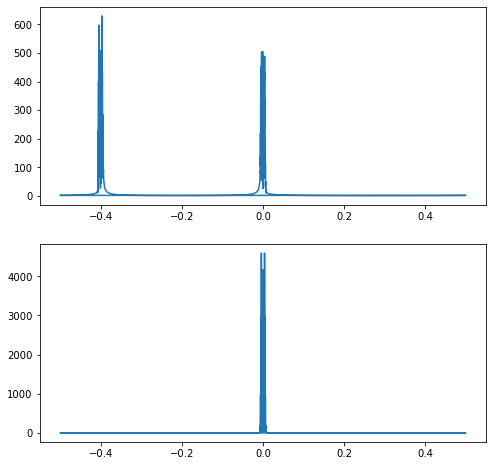

In [13]:
plt.figure(figsize=(8, 8))

w_hann = win.hann(len(x2))
y_hann = x2*w_hann

# fenêtre rectangulaire == pas de fenêtrage
plt.subplot(2, 1, 1)
plt.plot(*get_fft_mod(x1))

# fenêtre de Hann
plt.subplot(2, 1, 2)
plt.plot(*get_fft_mod(y_hann))

plt.show()

### Grossissement rudimentaire

L'agrandissement est de moindre qualité. (?)


In [1]:
plt.figure(figsize=(8, 8))

w = win.hann(len(x1))
y = x1 *  w

plt.subplot(2, 1, 1)
plt.plot(*get_fft_mod(x1))

plt.subplot(2, 1, 2)
plt.plot(*get_fft_mod(y))

plt.show()

NameError: name 'plt' is not defined